In [59]:
import pandas as pd
import numpy as np
import re,string
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [60]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nirai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nirai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nirai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nirai\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nirai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag,word_tokenize

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedKFold,cross_val_predict
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report)
try:
    from wordcloud import WordCloud
    WORDCLOUD_OK=True
except Exception:
    WORDCLOUD_OK=False
sns.set_theme(style="whitegrid")

In [63]:
DATA_PATH =r"C:\Users\nirai\Downloads\chatgpt_style_reviews_dataset.xlsx"
assert Path(DATA_PATH).exists(),f"File not found: {DATA_PATH}"
data=pd.read_excel(DATA_PATH)
print("Shape:",data.shape)
display(data.head())

Shape: (50, 12)


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-12-24,East list local interesting far magazine father.,Impressive natural language understanding. Alm...,1,darren55,25,9,Google Play,de,Nepal,2.0.4,No
1,2024-07-26,Road determine picture figure hard experience ...,Sometimes gives wrong answers or outdated info...,2,davistyler,35,14,Flipkart,es,Panama,2.6.5,No
2,2024-08-22,Policy social past analysis whole.,Great tool for generating content quickly. Int...,5,andrea59,94,10,App Store,es,Denmark,4.2.2,No
3,2025-04-24,News financial billion four foreign.,Great tool for generating content quickly. Sta...,3,dcooper,50,15,Amazon,de,Brunei Darussalam,4.4.2,No
4,2024-08-15,To skill she case sing stop likely.,Excellent for language translation and grammar...,1,christine79,33,11,Flipkart,fr,United States Minor Outlying Islands,5.1.1,Yes


In [64]:
lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words("english"))
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [65]:
def clean_text(text):
    text=str(text).lower()
    text=re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text=re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text=re.sub(r"\d+", " ", text)
    text=re.sub(r"\s+", " ", text).strip()
    tokens=word_tokenize(text)
    tokens=[w for w in tokens if w not in stop_words and len(w)>2]
    tagged=pos_tag(tokens)
    lemmatized=[lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w,t in tagged]
    return " ".join(lemmatized)

In [66]:
text_cols=[c for c in ["title","review","text"] if c in data.columns]
assert len(text_cols)>0,"No text columns found.Expected one of: title, review, text."

In [67]:
data["text_raw"]=data[text_cols].fillna("").agg(" ".join, axis=1)
data["clean_text"]=data["text_raw"].apply(clean_text)

In [68]:
assert "rating" in data.columns, "Dataset must have a 'rating' column."
data=data[~data["rating"].isna()].copy()
data["rating"]=pd.to_numeric(data["rating"],errors="coerce")
data=data[~data["rating"].isna()].copy()

In [69]:
data=data[data["clean_text"].str.len()>0].reset_index(drop=True)

In [70]:
print("After preprocessing rows:", len(data))
print(data[["text_raw","clean_text"]].head())

After preprocessing rows: 50
                                            text_raw  \
0  East list local interesting far magazine fathe...   
1  Road determine picture figure hard experience ...   
2  Policy social past analysis whole. Great tool ...   
3  News financial billion four foreign. Great too...   
4  To skill she case sing stop likely. Excellent ...   

                                          clean_text  
0  east list local interest far magazine father i...  
1  road determine picture figure hard experience ...  
2  policy social past analysis whole great tool g...  
3  news financial billion four foreign great tool...  
4  skill case sing stop likely excellent language...  


In [71]:
def map_binary_sentiment(rating):
    return 1 if float(rating)>=4 else 0
data["binary_sentiment"]=data["rating"].apply(map_binary_sentiment)
print("Binary class counts:\n",data["binary_sentiment"].value_counts())

Binary class counts:
 binary_sentiment
0    33
1    17
Name: count, dtype: int64


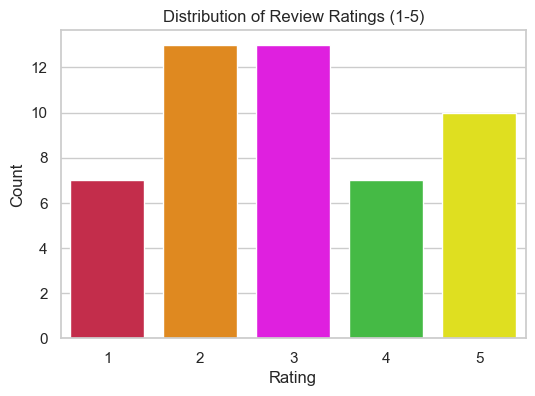

In [72]:
# (1) What is the distribution of review ratings?
plt.figure(figsize=(6,4))
sns.countplot(x="rating",hue="rating",data=data,palette=['crimson','darkorange','fuchsia','limegreen','yellow'],legend=False)
plt.title("Distribution of Review Ratings (1-5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

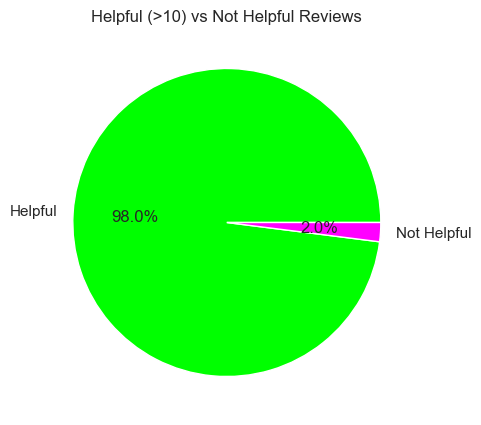

Helpful reviews (> 10 votes): 49, Not helpful: 1


In [73]:
# (2) How many reviews were marked as helpful (above a certain threshold)?
if "helpful_votes" in data.columns:
    threshold=10
    helpful=(data["helpful_votes"]>threshold).sum()
    not_helpful=(data["helpful_votes"]<=threshold).sum()
    plt.figure(figsize=(5,5))
    plt.pie([helpful,not_helpful],labels=["Helpful","Not Helpful"],autopct="%1.1f%%",colors=['lime','magenta'])
    plt.title(f"Helpful (>{threshold}) vs Not Helpful Reviews")
    plt.show()
    print(f"Helpful reviews (> {threshold} votes): {helpful}, Not helpful: {not_helpful}")
else:
    print("Column 'helpful_votes' not found — skipping helpfulness analysis")

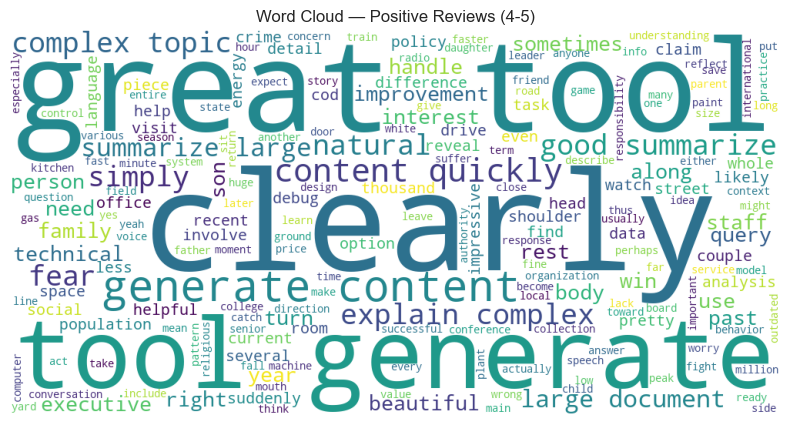

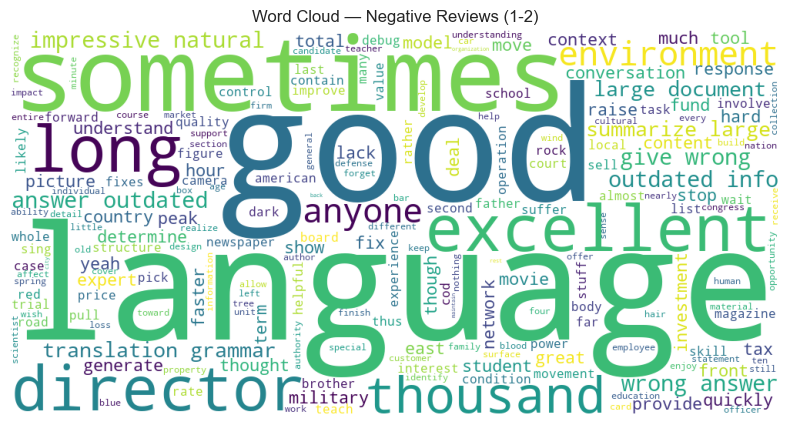

In [74]:
# (3) What are the most common keywords in positive vs. negative reviews?
if WORDCLOUD_OK:
    pos_text=" ".join(data.loc[data["rating"]>=4,"clean_text"])
    neg_text=" ".join(data.loc[data["rating"]<=2,"clean_text"])
    if len(pos_text.split())>10:
        plt.figure(figsize=(10,5))
        plt.imshow(WordCloud(width=1000,height=500,background_color="white").generate(pos_text))
        plt.axis("off")
        plt.title("Word Cloud — Positive Reviews (4-5)")
        plt.show()
    else:
        print("Not enough positive text for a word cloud.")
    if len(neg_text.split())>10:
        plt.figure(figsize=(10,5))
        plt.imshow(WordCloud(width=1000,height=500,background_color="white").generate(neg_text))
        plt.axis("off")
        plt.title("Word Cloud — Negative Reviews (1-2)")
        plt.show()
    else:
        print("Not enough negative text for a word cloud.")
else:
    print("wordcloud not installed — to enable word clouds: pip install wordcloud")


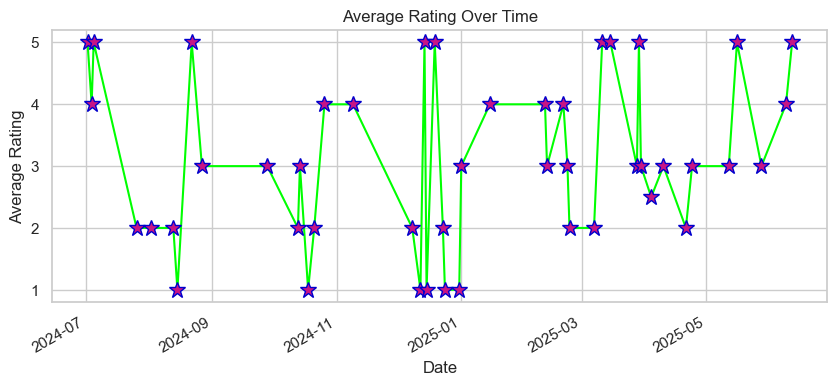

In [75]:
# (4)  How has the average rating changed over time?
data["date"]=pd.to_datetime(data["date"])
avg_rating_time=data.groupby("date")["rating"].mean()
plt.figure(figsize=(10,4))
avg_rating_time.plot(kind="line",marker='*',markerfacecolor='mediumvioletred',markeredgecolor='mediumblue',markersize=12,color='lime')
plt.title("Average Rating Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.show()

In [76]:
# (5) How do ratings vary by user location?
import plotly.express as px
location_avg=data.groupby("location")["rating"].mean().reset_index()
fig=px.choropleth(location_avg,locations="location",locationmode="country names",color="rating",color_continuous_scale="Viridis",title="🌍 Average Ratings by Location")
fig.show()

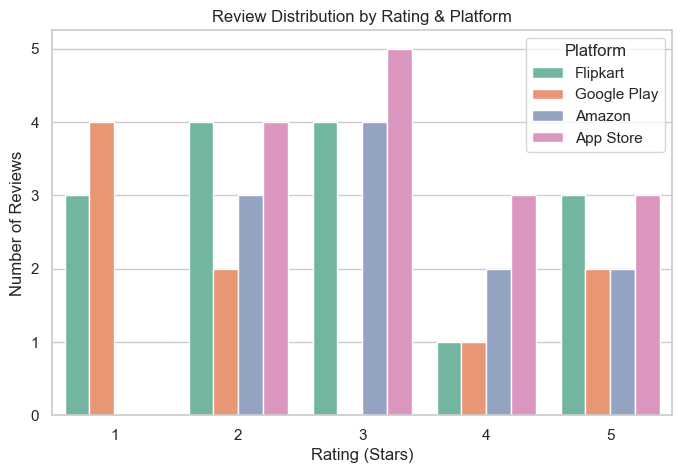

In [77]:
# (6) Which platform (Web vs Mobile) gets better reviews?
if "platform" in data.columns and "rating" in data.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(x="rating",y="count",hue="platform",data=data.groupby(["rating","platform"]).size().reset_index(name="count"),palette="Set2")
    plt.title("Review Distribution by Rating & Platform")
    plt.xlabel("Rating (Stars)")
    plt.ylabel("Number of Reviews")
    plt.legend(title="Platform")
    plt.show()

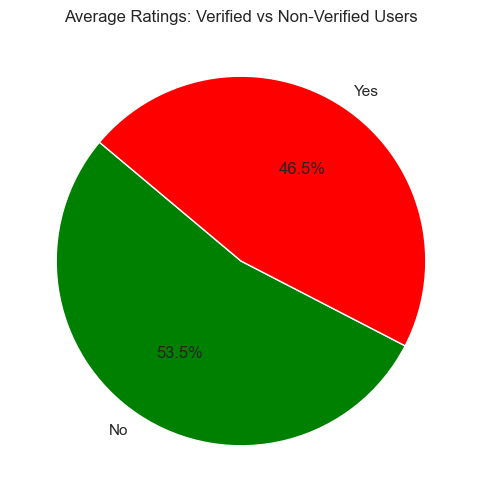

In [78]:
# (7) Are verified users more satisfied than non-verified ones?
avg_ratings=data.groupby("verified_purchase")["rating"].mean()
labels=avg_ratings.index
sizes=avg_ratings.values
colors=['green','red']  
plt.figure(figsize=(6,6))
plt.pie(sizes,labels=labels,colors=colors,autopct='%1.1f%%',startangle=140)
plt.title("Average Ratings: Verified vs Non-Verified Users")
plt.show()

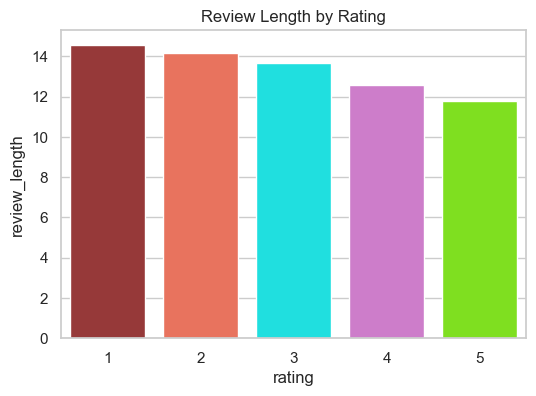

In [79]:
# (8) What’s the average length of reviews per rating category?
custom_palette=['brown','tomato','aqua','orchid','chartreuse']
plt.figure(figsize=(6,4))
sns.barplot(x="rating",y="review_length",data=data,palette=custom_palette,hue="rating",legend=False,errorbar=None)
plt.title("Review Length by Rating")
plt.show()

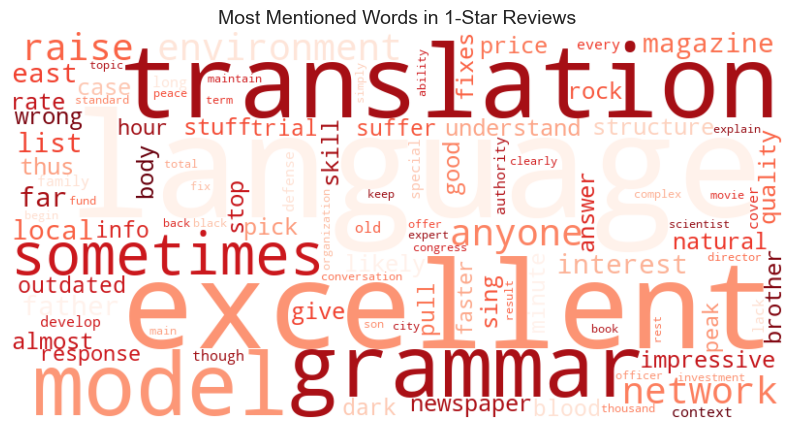

In [80]:
# (9) What are the most mentioned words in 1-star reviews?
from wordcloud import WordCloud
one_star=data.loc[data["rating"]==1,"clean_text"]
if len(one_star)>0:
    text=" ".join(one_star)
    wordcloud=WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="Reds",
        max_words=100
    ).generate(text)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Mentioned Words in 1-Star Reviews", fontsize=14)
    plt.show()
else:
    print("No 1-star reviews present")

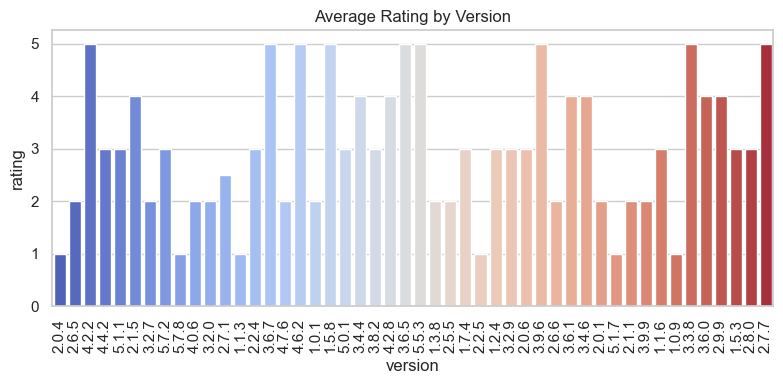

In [81]:
# (10) What ChatGPT version received the highest average rating?
plt.figure(figsize=(8,4))
barplot = sns.barplot(x="version",y="rating",data=data,palette="coolwarm",estimator=lambda x: sum(x)/len(x),errorbar=None,hue="version",legend=False)
barplot.tick_params(axis='x',rotation=90)
plt.title("Average Rating by Version")
plt.tight_layout()
plt.show()

In [82]:
vectorizer=TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_tfidf=vectorizer.fit_transform(data["clean_text"])
y=data["binary_sentiment"].values
print("TF-IDF shape:",X_tfidf.shape)

TF-IDF shape: (50, 1081)


In [83]:
clf=LogisticRegression(class_weight='balanced',max_iter=1000,random_state=42)
scores=cross_val_score(clf,X_tfidf,y,cv=5,scoring='accuracy')
print("Cross-validated accuracy scores (Binary TF-IDF):", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validated accuracy scores (Binary TF-IDF): [0.7 0.7 0.7 0.7 0.4]
Mean accuracy: 0.6399999999999999


In [84]:
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
y_pred_full=np.zeros(len(data),dtype=int)
for train_index,test_index in skf.split(X_tfidf,y):
    X_train_fold,X_test_fold=X_tfidf[train_index],X_tfidf[test_index]
    y_train_fold=y[train_index]
    clf.fit(X_train_fold,y_train_fold)
    y_pred_full[test_index]=clf.predict(X_test_fold)
results=pd.DataFrame({
    "Review": data["clean_text"],
    "True Sentiment": y,
    "Predicted Sentiment": y_pred_full,
    "Correct": y_pred_full==y
})
print("\nSample predictions:")
print(results.head())
print("\nOverall accuracy (OOF):", results["Correct"].mean())


Sample predictions:
                                              Review  True Sentiment  \
0  east list local interest far magazine father i...               0   
1  road determine picture figure hard experience ...               0   
2  policy social past analysis whole great tool g...               1   
3  news financial billion four foreign great tool...               0   
4  skill case sing stop likely excellent language...               0   

   Predicted Sentiment  Correct  
0                    0     True  
1                    0     True  
2                    0    False  
3                    0     True  
4                    0     True  

Overall accuracy (OOF): 0.58


In [85]:
accuracy=accuracy_score(y,y_pred_full)
precision=precision_score(y,y_pred_full,zero_division=0)
recall=recall_score(y,y_pred_full,zero_division=0)
f1=f1_score(y,y_pred_full,zero_division=0)
try:
    clf.fit(X_tfidf,y)
    y_proba=clf.predict_proba(X_tfidf)[:,1]
    roc_auc=roc_auc_score(y, y_proba)
except Exception:
    roc_auc=np.nan
cm=confusion_matrix(y,y_pred_full)
print("\n Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc if not np.isnan(roc_auc) else 'N/A'}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y,y_pred_full,target_names=["Non-Positive","Positive"],zero_division=0))


 Evaluation Metrics:
Accuracy:  0.5800
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   1.0

Confusion Matrix:
[[29  4]
 [17  0]]

Classification Report:
              precision    recall  f1-score   support

Non-Positive       0.63      0.88      0.73        33
    Positive       0.00      0.00      0.00        17

    accuracy                           0.58        50
   macro avg       0.32      0.44      0.37        50
weighted avg       0.42      0.58      0.48        50

